# Example of using ClinTrajan, illustrated with Myocardial Infarction Dataset


# Part 1. Quantification of Data

### Importing libraries for quantification

In [593]:
import sys

sys.path.append('./code')

from importlib import reload  

import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

from clintraj_qi import *
from clintraj_util import *
from clintraj_optiscale import *

def decode_ordinal_variables(XX,variable_types,cik):
    k = 0
    for i,vt in enumerate(variable_types):
        if vt=='ORDINAL':
            colmn = XX[:,i]
            for j in range(cik[k].shape[0]):
                inds = np.where(np.abs(colmn-cik[k][j])<1e-6)[0]
                colmn[inds] = j
            XX[:,i] = colmn
            k+=1
    return XX

def quantify_ordinal_variables(XX,variable_types,cik):
    k = 0
    for i,vt in enumerate(variable_types):
        if vt=='ORDINAL':
            colmn = XX[:,i]
            for j in range(cik[k].shape[0]):
                inds = np.where(colmn.astype(np.int32)==j)[0]
                colmn[inds] = cik[k][j]
            XX[:,i] = colmn
            k+=1
    return XX

def save_point_projections_in_table(vec_labels_by_branches, PseudoTimeTraj):
    point2trajmap = {}
    point2trajnamemap = {}
    point2pst = {}
    alltrajnames = []
    alltrajnums = []
    traj_binary = {}
    for i in range(len(vec_labels_by_branches)):
        point2trajmap[i] = []
        point2trajnamemap[i] = []
    for i,pstt in enumerate(PseudoTimeTraj):
        pstt = PseudoTimeTraj[i]
        TrajName = 'Trajectory:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
        alltrajnames.append(TrajName)
        alltrajnums.append(pstt['Trajectory'][-1])
        points = pstt['Points']
        pseudotime = pstt['Pseudotime']
        for k,p in enumerate(points):
            #point2trajmap[p].append(TrajName)
            point2trajmap[p].append(pstt['Trajectory'][-1])
            point2trajnamemap[p].append(TrajName)
            point2pst[p] = pseudotime[k]
        traj_binary[TrajName] = np.zeros(len(vec_labels_by_branches)).astype(np.int32)

    point2trajmap_list = []
    point2pst_list = []

    for i in range(len(vec_labels_by_branches)):
        point2trajmap_list.append(point2trajmap[i])
        point2pst_list.append(point2pst[i])
        for tn in point2trajnamemap[i]:
            traj_binary[tn][i] = 1

    data={'Point':np.arange(len(vec_labels_by_branches))+1,
                            'Segment':vec_labels_by_branches,
                           'Pseudotime':point2pst_list,
                           'Trajectories':point2trajmap_list}
    for tn in alltrajnames:
        data[tn] = traj_binary[tn]
    df = pd.DataFrame(data=data)
    return df

['/mnt/c/MyPrograms/Python/ClinTrajan/test', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/home/zinovyev/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/zinovyev/.local/lib/python3.7/site-packages/IPython/extensions', '/home/zinovyev/.ipython', './code', '/home/zinovyev/anaconda3/lib/python3.7/site-packages', '/mnt/c/MyPrograms/__github/DAPCA', './code']


### Loading data (categorical variables are assumed to be dummy-encoded already)

In [589]:
df = pd.read_csv('data/infarction/all_dummies.txt',delimiter='\t')
display(df)
quantify_nans(df)

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,...,REC_IM,P_IM_STEN,LET_IS_0,LET_IS_1,LET_IS_2,LET_IS_3,LET_IS_4,LET_IS_5,LET_IS_6,LET_IS_7
0,1,77.0,1,2.0,1.0,1.0,2.0,3.0,0.0,7.0,...,0,0.0,1,0,0,0,0,0,0,0
1,2,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,1,0,0,0,0,0,0,0
2,3,52.0,1,0.0,0.0,0.0,2.0,2.0,0.0,2.0,...,0,0.0,1,0,0,0,0,0,0,0
3,4,68.0,0,0.0,0.0,0.0,2.0,2.0,0.0,3.0,...,0,0.0,1,0,0,0,0,0,0,0
4,5,60.0,1,0.0,0.0,0.0,2.0,3.0,0.0,7.0,...,0,0.0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569,1695,77.0,0,0.0,0.0,0.0,0.0,2.0,0.0,7.0,...,0,0.0,0,0,0,1,0,0,0,0
1570,1696,77.0,0,0.0,4.0,2.0,1.0,2.0,0.0,7.0,...,0,0.0,0,0,0,1,0,0,0,0
1571,1697,70.0,0,0.0,6.0,2.0,1.0,2.0,0.0,7.0,...,0,0.0,0,1,0,0,0,0,0,0
1572,1699,79.0,0,2.0,2.0,2.0,1.0,2.0,0.0,7.0,...,0,0.0,0,1,0,0,0,0,0,0


Missing values 4780 (2.468982758442578%)
Number of complete rows: 533 (33.86277001270648%)


### Detecting variable types

In [442]:
variable_types, binary, continuous, ordinal = detect_variable_type(df,10,verbose=False)

### Simplest univariate quantification (can work when there are missing values)

In [443]:
dfq,replacement_info = quantify_dataframe_univariate(df,variable_types)
with open('temp.txt','w') as fid:
    fid.write(replacement_info)

### Simplest missing value imputation using SVD computed at complete part of the dataset

Matrix shape: (533, 123)
Effective linear dimension 24
Full matrix shape (1574, 123)


,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,...,REC_IM,P_IM_STEN,LET_IS_0,LET_IS_1,LET_IS_2,LET_IS_3,LET_IS_4,LET_IS_5,LET_IS_6,LET_IS_7
0,1,77.0,1,2,1,1,2,3,0,7,...,0,0,1,0,0,0,0,0,0,0
1,2,55.0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,3,52.0,1,0,0,0,2,2,0,2,...,0,0,1,0,0,0,0,0,0,0
3,4,68.0,0,0,0,0,2,2,0,3,...,0,0,1,0,0,0,0,0,0,0
4,5,60.0,1,0,0,0,2,3,0,7,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569,1695,77.0,0,0,0,0,0,2,0,7,...,0,0,0,0,0,1,0,0,0,0
1570,1696,77.0,0,0,4,2,1,2,0,7,...,0,0,0,0,0,1,0,0,0,0
1571,1697,70.0,0,0,6,2,1,2,0,7,...,0,0,0,1,0,0,0,0,0,0
1572,1699,79.0,0,2,2,2,1,2,0,7,...,0,0,0,1,0,0,0,0,0,0


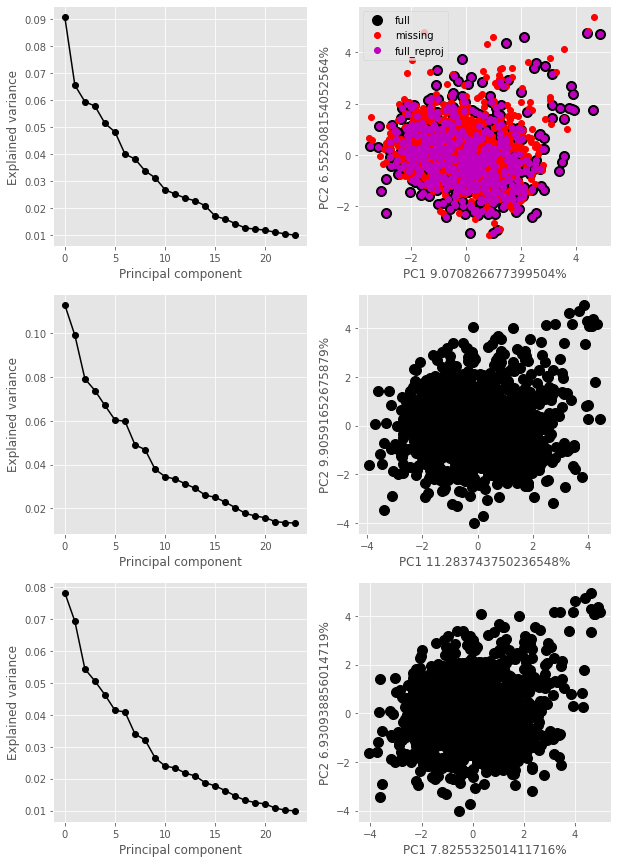

In [444]:
dfq_imputed = SVDcomplete_imputation_method(dfq, variable_types, verbose=True,num_components=-1)
#dequant_info = invert_quant_info(replacement_info)
dequant_info = invert_quant_info(load_quantification_info('temp.txt'))
df_imputed = dequantify_table(dfq_imputed,dequant_info)
display(df_imputed)

## Now we quantify (and optimize) the ordinal variables via optimal scaling

Removing  0 columns
[2. 1. 0. ... 0. 2. 2.]

 Initial Q2: 29.79798242307683
Initial quantification table:
[array([0., 1., 2., 3., 4., 5., 6.]), array([0., 1., 2., 3., 4., 5., 6.]), array([0., 1., 2., 3., 4., 8.]), array([0., 1., 2.]), array([0., 1., 2., 3.]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7., 10.]), array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3., 4.]), array([1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([0., 1., 2., 3., 4., 6., 7.]), array([0., 1., 2., 3.]), array([0., 1., 2., 4.]), array([ 0.,  1., 10.]), array([0., 1., 2., 3., 4., 5., 6.]), array([0., 1., 2., 3.]), array([0., 1., 2.]), array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3.]), array([0., 1., 2.])]
Monotonicity: (True, 1.0)
Iteration 0 Q2= 29.79798242307683
Iteration 1 Q2= 29.797982423076846
Iteration 2 Q2= 30.274745044053148
Iteration 3 Q2= 30.82934923850175
Iteration 4 Q2= 30.867014376251262
Iteration 5 Q2= 30.883540026

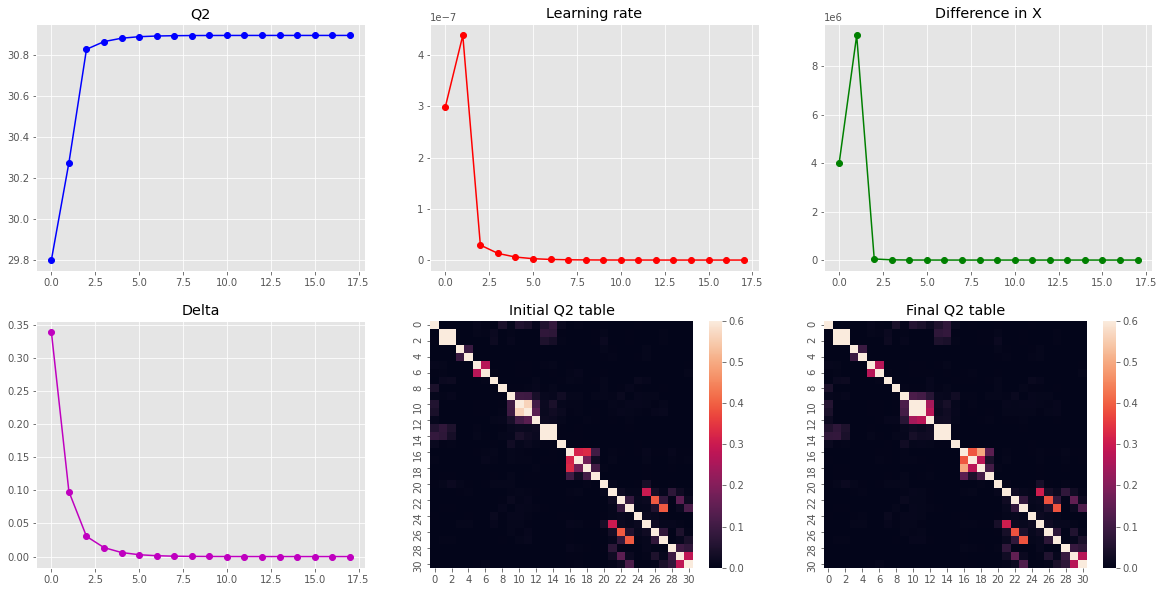

In [538]:
df = remove_constant_columns_from_dataframe(df_imputed)
variable_names = [str(s) for s in df.columns[1:]]
X = df[df.columns[1:]].to_numpy()
X_original = X.copy()
print(X_original[:,2])
_,cik = optimal_scaling(X,variable_types,verbose=True,vmax=0.6)
print(X_original[:,2])
X_scaled = quantify_ordinal_variables(X,variable_types,cik)
X = X_scaled.copy()
print(X_original[:,2])

#### OK, we finished preparing the data matrix X, which is now complete and properly quantified. We also keep the 'original matrix' X_original, with 'raw' values of the variables (will be needed for visualizations)

# Part 2. Computing the principal tree

## Loading ClinTrajan libraries

In [95]:
from clintraj_eltree import *
from clintraj_util import *
from clintraj_ml import *
from clintraj_optiscale import *


## First of all, we will reduce the dimension using PCA

In [540]:
reduced_dimension = 12
mean_val_original = np.mean(X,axis=0)
std_original = np.std(X,axis=0)
std_original[np.where(std_original==0)] = 1
Xs = (X-mean_val_original)/std_original
pca = PCA(n_components=reduced_dimension,svd_solver='full')
Y = pca.fit_transform(Xs)
v = pca.components_.T
mean_val = np.mean(Xs,axis=0)
X = Y[:,0:reduced_dimension]

## We are ready to compute the principal tree, let us do it

In [576]:
nnodes = 50
tree_elpi = elpigraph.computeElasticPrincipalTree(X,nnodes,
                                                  alpha=0.01,Mu=0.1,Lambda=0.05,
                                                  FinalEnergy='Penalized',Do_PCA=True)
tree_elpi = tree_elpi[0]
# some additional pruning of the graph
prune_the_tree(tree_elpi)
# extend the leafs to reach the extreme data points
tree_extended = ExtendLeaves_modified(X, tree_elpi, Mode = "WeightedCentroid", ControlPar = 0, DoSA = False)

Removed 3 vertices and 3 edges


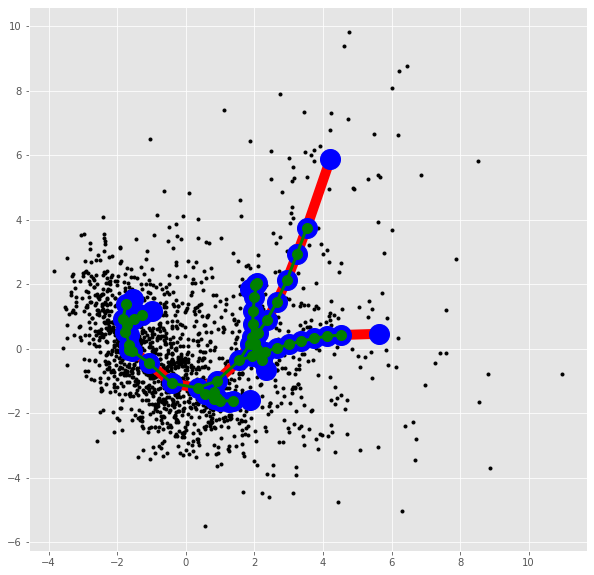

In [578]:
# Visualize how leaf extension was done

ix = 0
iy = 1

t = tree_extended
plt.figure(figsize=(10,10))
plt.plot(X[:,ix],X[:,iy],'k.')
nodes = t['NodePositions']
edges = t['Edges'][0]
for e in edges:
    plt.plot([nodes[e[0],ix],nodes[e[1],ix]],[nodes[e[0],iy],nodes[e[1],iy]],'r-',linewidth=10)
plt.plot(nodes[:,ix],nodes[:,iy],'bo',markersize=20)
    
t = tree_elpi
nodes = t['NodePositions']
edges = t['Edges'][0]
for e in edges:
    plt.plot([nodes[e[0],ix],nodes[e[1],ix]],[nodes[e[0],iy],nodes[e[1],iy]],'g-',linewidth=3)
plt.plot(nodes[:,ix],nodes[:,iy],'go',markersize=10)
    
plt.show()

### Create accuracy/complexity plot as in https://doi.org/10.1016/j.camwa.2012.12.009


/home/zinovyev/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
/home/zinovyev/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


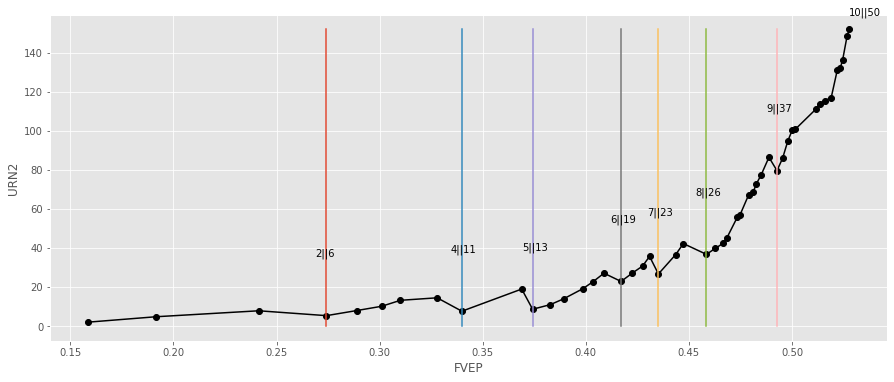

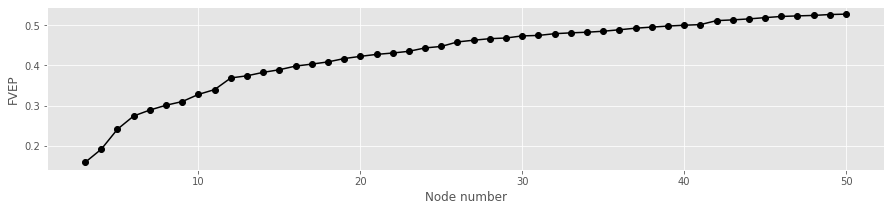

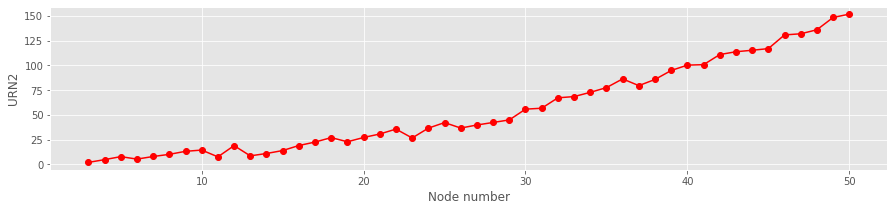

In [579]:
from scipy.signal import find_peaks

report = pd.DataFrame(data=tree_elpi['ReportTable'])
report = pd.DataFrame(data={'CODE':report[report.columns[0]].astype(np.str),
                       'FVEP':report['FVEP'].astype(np.float32),
                       'URN2':report['URN2'].astype(np.float32),
                       'NNODES':report['NNODES'].astype(np.float32)})
x = report[['FVEP','URN2','NNODES']].to_numpy()
codes = report['CODE']
plt.figure(figsize=(15,6))
plt.plot(x[:,0],x[:,1],'ko-')
plt.xlabel('FVEP')
plt.ylabel('URN2')
peaks = np.array(find_peaks(-x[:,1]))
for p in peaks[0]:
    plt.plot([x[p,0],x[p,0]],[0,np.max(x[:,1])])
    plt.text(x[p,0]-np.max(x[:,0]/100),x[p,1]+np.max(x[:,1])/5,codes[p])
plt.text(x[len(x)-1,0],x[len(x)-1,1]+np.max(x[:,1])/20,codes[len(x)-1])
plt.show()
plt.figure(figsize=(15,3))
plt.plot(x[:,2],x[:,0],'ko-')
plt.xlabel('Node number')
plt.ylabel('FVEP')
plt.show()
plt.figure(figsize=(15,3))
plt.plot(x[:,2],x[:,1],'ro-')
plt.xlabel('Node number')
plt.ylabel('URN2')
plt.show()

## Now we will create two data partitioning, by nodes of the principal tree and by the linear segments of the principal tree

In [580]:
# paritioning the data by tree branches
vec_labels_by_branches = partition_data_by_tree_branches(X,tree_extended)
print(len(set(vec_labels_by_branches)),'labels generated')
# paritioning the data by proximity to nodes
nodep = tree_elpi['NodePositions']
partition, dists = elpigraph.src.core.PartitionData(X = X, NodePositions = nodep, 
                                                    SquaredX = np.sum(X**2,axis=1,keepdims=1),
                                                    MaxBlockSize = 100000000, TrimmingRadius = np.inf
                                                    )
partition_by_node = np.zeros(len(partition))
for i,p in enumerate(partition):
    partition_by_node[i] = p[0]

14 labels generated


## Let us visualize the tree, with data points, colored by the tree segments

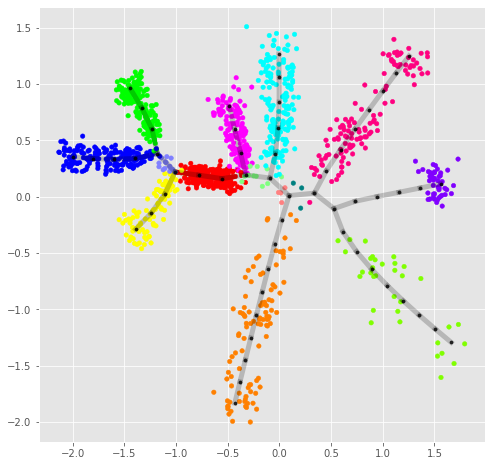

In [581]:
fig = plt.figure(figsize=(8, 8))
visualize_eltree_with_data(tree_extended,X,X_original,vec_labels_by_branches,variable_names,
                          Color_by_partitioning = True, 
                          visualize_partition = vec_labels_by_branches)
plt.show()

## Now let us show, on top of the tree, lethal cases, and show the lethality trend by the edge width

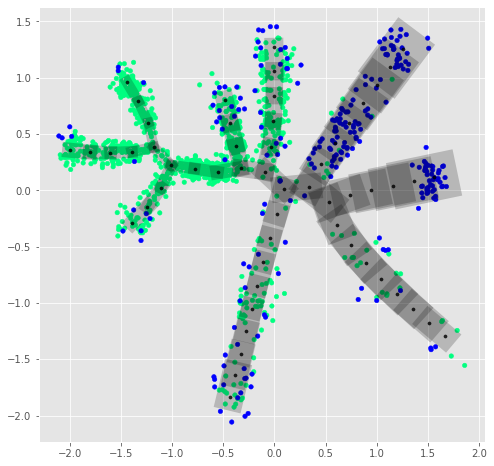

In [582]:
fig = plt.figure(figsize=(8, 8))
non_lethal_feature = 'LET_IS_0'

visualize_eltree_with_data(tree_extended,X,X_original,'k',variable_names,
                            principal_component_vectors=v,mean_vector=mean_val,                           
                          Color_by_feature=non_lethal_feature, Feature_Edge_Width=non_lethal_feature,
                           Invert_Edge_Value=True,Min_Edge_Width=10,Max_Edge_Width=50,
                           Visualize_Edge_Width_AsNodeCoordinates=True,cmap='winter')
plt.show()

## Let us higlight patients with AGE<65 and having bronchyal asthma in their anamneses

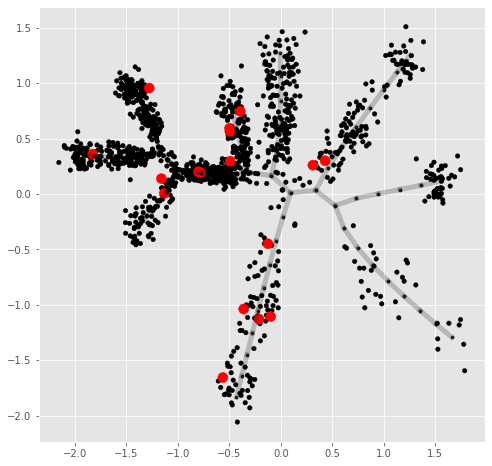

In [583]:
fig = plt.figure(figsize=(8, 8))
inds = np.where((X_original[:,variable_names.index('AGE')]<=65)&(X_original[:,variable_names.index('zab_leg_03')]==1))[0]
colors = ['k' for i in range(len(X))]
for i in inds:
    colors[i] = 'r'
colors = list(colors)


#def visualize_eltree_with_data(tree_elpi,X,X_original,color,variable_names,principal_component_vectors=None,mean_vector=None,


visualize_eltree_with_data(tree_extended,X,X_original,colors,variable_names,
                          highlight_subset=inds,Big_Point_Size=100,cmap='hot')

plt.show()

## Now let us quantify the pseudotime value, for each trajectory

#### 1. We need to specify the root node. In order to do this, we will highlight all cases without any myocardial infarction complications, and will select the node where the complications are rare. In order to make the selection visual, we will show the node numbers as well

['r', 'k'] [945 629]


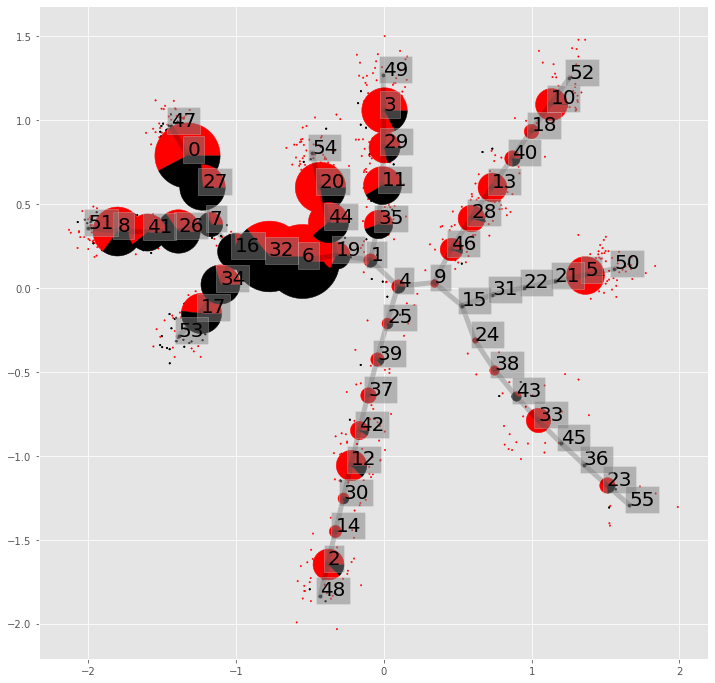

Root node= 6


In [584]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1,1,1)
complication_vars = ['FIBR_PREDS','PREDS_TAH','JELUD_TAH','FIBR_JELUD',
                     'A_V_BLOK','OTEK_LANC','RAZRIV','DRESSLER',
                     'ZSN','REC_IM','P_IM_STEN']
inds_compl = [variable_names.index(a) for a in complication_vars]
lethal = 1-X_original[:,variable_names.index('LET_IS_0')]
has_complication = np.sum(X_original[:,inds_compl],axis=1)>0
inds = np.where((has_complication==0)&(lethal==0))[0]
colors = ['r' for i in range(len(X))]
for i in inds:
    colors[i] = 'k'
visualize_eltree_with_data(tree_extended,X,X_original,colors,variable_names,
                            principal_component_vectors=v,mean_vector=mean_val,
                          highlight_subset=inds,Big_Point_Size=2,Normal_Point_Size=2,showNodeNumbers=True)
add_pie_charts(ax,tree_extended['NodePositions2D'],colors,['r','k'],partition,scale=30)
plt.show()
root_node = 6
print('Root node=',root_node)

#### 2. Now we are ready to quantify pseudo-time

In [585]:
all_trajectories,all_trajectories_edges = extract_trajectories(tree_extended,root_node)
print(len(all_trajectories),' trajectories found.')
ProjStruct = project_on_tree(X,tree_extended)
PseudoTimeTraj = quantify_pseudotime(all_trajectories,all_trajectories_edges,ProjStruct)

9  trajectories found.


#### 3. Let us find all associations by regression of a clinical variable with pseudotime along all trajectories

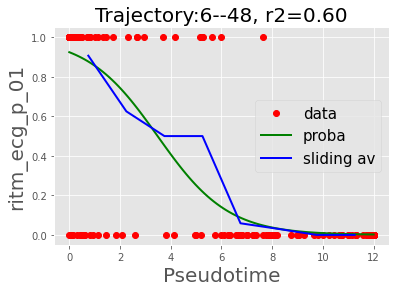

1 ('Trajectory:6--48', 'ritm_ecg_p_01', 0.604942037827944)


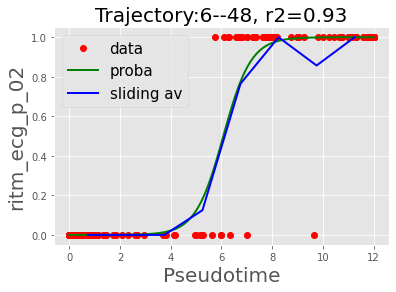

1 ('Trajectory:6--48', 'ritm_ecg_p_02', 0.9299526707234618)


In [586]:
vars = ['ritm_ecg_p_01','ritm_ecg_p_02','ritm_ecg_p_04']
#vars = variable_names
for var in vars:
    List_of_Associations = regression_of_variable_with_trajectories(PseudoTimeTraj,var,variable_names,
                                                                    variable_types,X_original,R2_Threshold=0.5,
                                                                    producePlot=True,
                                                                    Continuous_Regression_Type='gpr',
                                                                    verbose=True)

#### 4. We can plot several variable dependencies against pseudotime

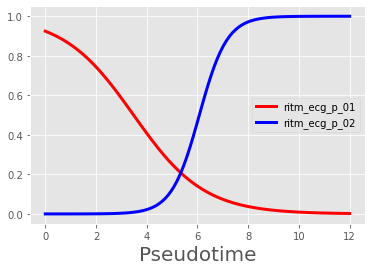

In [587]:
pstt = PseudoTimeTraj[1]
colors = ['r','b','g']
for i,var in enumerate(vars):
    vals = draw_pseudotime_dependence(pstt,var,variable_names,variable_types,X_original,colors[i],
                                               linewidth=3,draw_datapoints=False)
plt.legend()
plt.show()


#### 5. Now let us show how we can plot anything as a function of pseudotime, for example, cumulative hazard of death estimated using standard survival analysis

/home/zinovyev/anaconda3/lib/python3.7/site-packages/lifelines/fitters/nelson_aalen_fitter.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.ci_labels[0]: hazard_ * np.exp(z * std_hazard_ / hazard_),
/home/zinovyev/anaconda3/lib/python3.7/site-packages/lifelines/fitters/nelson_aalen_fitter.py:235: RuntimeWarning: invalid value encountered in true_divide
  self.ci_labels[1]: hazard_ * np.exp(-z * std_hazard_ / hazard_),
/home/zinovyev/anaconda3/lib/python3.7/site-packages/lifelines/fitters/nelson_aalen_fitter.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.ci_labels[0]: hazard_ * np.exp(z * std_hazard_ / hazard_),
/home/zinovyev/anaconda3/lib/python3.7/site-packages/lifelines/fitters/nelson_aalen_fitter.py:235: RuntimeWarning: invalid value encountered in true_divide
  self.ci_labels[1]: hazard_ * np.exp(-z * std_hazard_ / hazard_),
/home/zinovyev/anaconda3/lib/python3.7/site-packages/lifelines/fitters/nelson_aalen_fitter.py:234: RuntimeWarn

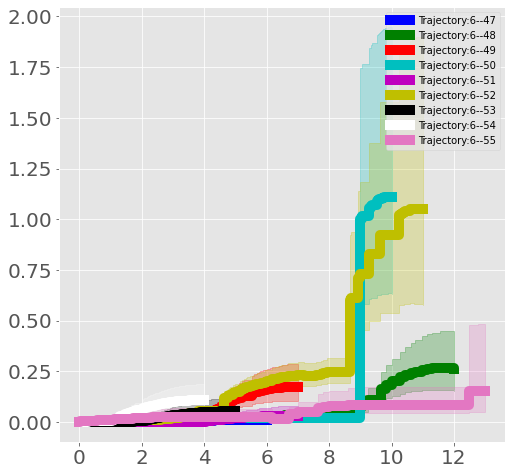

In [590]:
import lifelines
from lifelines import SplineFitter
from lifelines import NelsonAalenFitter
from lifelines import KaplanMeierFitter
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','tab:pink','tab:green']

event_data = np.zeros((len(df),2))
events = 1-np.array(df['LET_IS_0'])
label = 'Death'

for i,pstt in enumerate(PseudoTimeTraj):
    points = pstt['Points']
    times = pstt['Pseudotime']
    for i,p in enumerate(points):
        event_data[p,0] = times[i]
        event_data[p,1] = events[p]

plt.figure(figsize=(8,8))

for i,pstt in enumerate(PseudoTimeTraj):
    TrajName = 'Trajectory:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
    points = pstt['Points']
    naf = NelsonAalenFitter()
    T = event_data[points,0]
    E = event_data[points,1]
    naf.fit(event_data[points,0], event_observed=event_data[points,1],label=TrajName)  
    naf.plot_hazard(bandwidth=3.0,fontsize=20,linewidth=10,color=colors[i])



#### 6. Plot a feature as a function of pseudotime along several trajectories

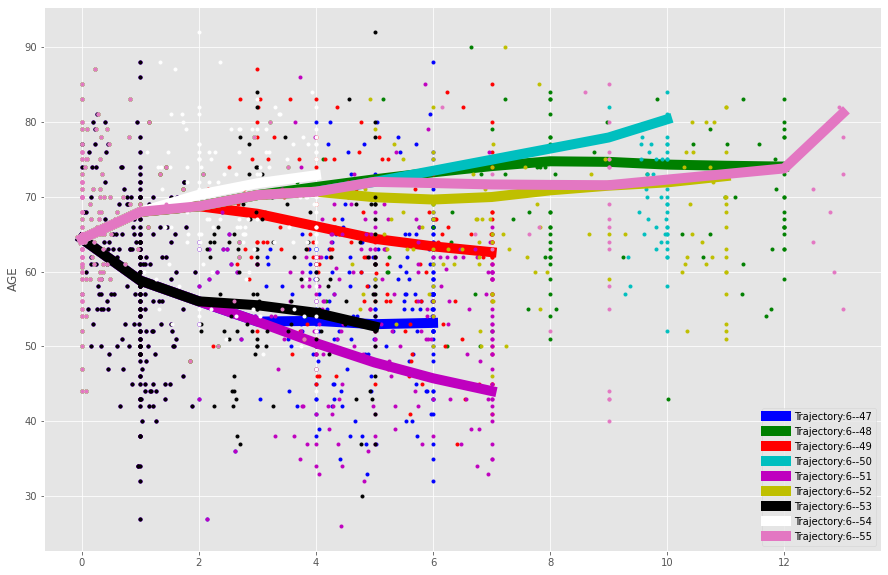

In [591]:
import seaborn as sns

#feature = 'GB'
feature = 'AGE'
#feature = 'LET_IS_0'
#feature = 'K_BLOOD'
irx = variable_names.index(feature)
nodes = tree_extended['NodePositions']
nodes_real = nodes@v.T+mean_val
#nodes_real = nodes_real*std_original+mean_val_original
nodes_real = nodes_real*np.std(X_original)+np.mean(X_original,axis=0)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','tab:pink','tab:green']

plt.figure(figsize=(15,10))

for i,pstt in enumerate(PseudoTimeTraj):
    pstt = PseudoTimeTraj[i]
    TrajName = 'Trajectory:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
    points = pstt['Points']
    pseudotime = pstt['Pseudotime']
    nodes_irx = pstt['Trajectory']
    plt.plot(np.arange(len(nodes_irx)),nodes_real[nodes_irx,irx],linewidth=10,color=colors[i],label=TrajName)
    plt.plot(pseudotime,X_original[points,irx],'.',color=colors[i])
    plt.ylabel(feature)
    
plt.legend()
plt.show()

#### 7. Export the results of the analysis to tables that can be analyzed elsewhere

In [592]:
vec_labels_by_branches = partition_data_by_tree_branches(X,tree_extended).astype(np.int32)
table2save = save_point_projections_in_table(vec_labels_by_branches,PseudoTimeTraj)
table2save.to_csv('results/infarction/all_dummies_treetable.txt',sep='\t',index=False)

#### 8. Pretend that part of the data (for this, example, first 100 points) was not used in the analysis, and then project it back onto the tree

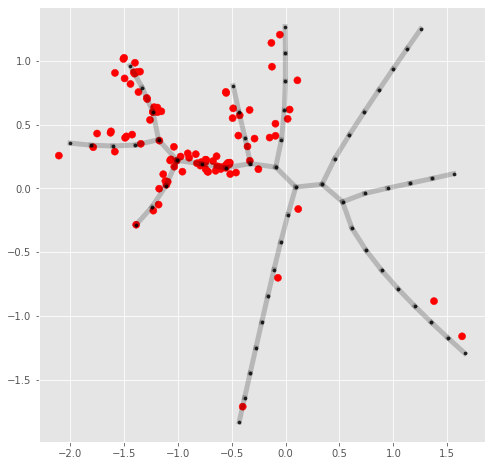

In [594]:
new_data = X_original[0:100,:].copy()
new_data_orig = new_data.copy()

# We first should normalize data and find it in the same space where the tree was constructed
new_data = quantify_ordinal_variables(new_data,variable_types,cik)
new_data = (new_data-mean_val_original)/std_original
new_data = pca.transform(new_data)

# Then we project the new data onto already constructed tree
ProjStruct_new = project_on_tree(new_data,tree_extended)
PseudoTimeTraj_new = quantify_pseudotime(all_trajectories,all_trajectories_edges,ProjStruct_new)

# Show new data
fig = plt.figure(figsize=(8, 8))
visualize_eltree_with_data(tree_extended,new_data,new_data_orig,'r',variable_names,
                          Normal_Point_Size=50,cmap='hot')
plt.show()

# Now save the projections of the new data into a file
vec_labels_by_branches_new = partition_data_by_tree_branches(new_data,tree_extended).astype(np.int32)
df_new = save_point_projections_in_table(vec_labels_by_branches_new,PseudoTimeTraj_new)
df_new.to_csv('results/infarction/all_dummies_treetable_new.txt',sep='\t',index=False)
